In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [14]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [3]:
data = pd.read_csv('final-data.csv')
data_initial = pd.read_csv('final-data.csv')

In [4]:
data['Week Endings'] = pd.to_datetime(data['Week Endings'], errors = 'raise')
data_initial['Week Endings'] = pd.to_datetime(data_initial['Week Endings'], errors = 'raise')
data_initial = data_initial.sort_values(by='Week Endings', ascending=True)
data = data.sort_values(by='Week Endings', ascending=True)

In [5]:
# Truncating data after the release of the lion king movie
lk_release = datetime.date(2019, 7, 19)
boolean_mask = data['Week Endings'].dt.date < lk_release

In [6]:
# Data after the series has been truncated
print(data[boolean_mask].tail(5).to_string())
print(data[boolean_mask].shape)

    Week Endings  Avg Ticket Price ($)  Top Ticket Price ($)  Seats Sold  Seats in Theatre   % Cap
141   2019-06-16                171.79                 225.0       13565              1696   99.98
140   2019-06-23                178.53                 225.0       13569              1696  100.01
139   2019-06-30                179.18                 225.0       13550              1696   99.87
138   2019-07-07                190.91                 225.0       13519              1696   99.64
137   2019-07-14                187.67                 225.0       12759              1696   94.04
(1129, 6)


In [7]:
data = data[boolean_mask]

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1129 entries, 1265 to 137
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Week Endings          1129 non-null   datetime64[ns]
 1   Avg Ticket Price ($)  1129 non-null   float64       
 2   Top Ticket Price ($)  1129 non-null   float64       
 3   Seats Sold            1129 non-null   int64         
 4   Seats in Theatre      1129 non-null   int64         
 5   % Cap                 1129 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 61.7 KB


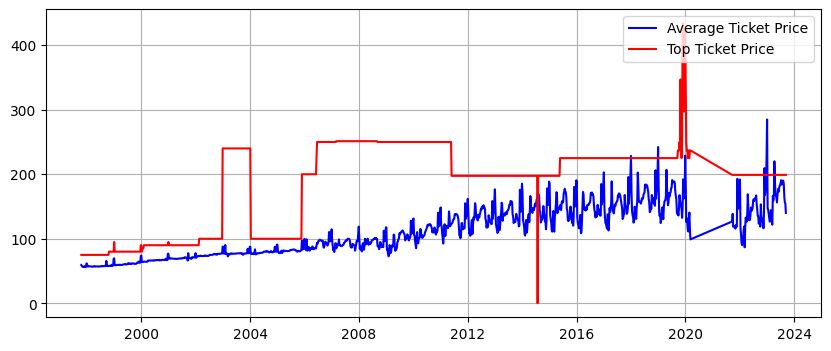

In [9]:
# Some basic plotting to check data and 
# data scale to determine whether data needs to be normalised or not
# before being used with the sequence model for prediction
# year = np.array(range(data.shape[0])) + 757
time = data['Week Endings']
time_initial = data_initial['Week Endings']
plt.figure(figsize=(10, 4))
plt.grid(True)
plt.plot(time, data['Avg Ticket Price ($)'], color='b', label="Average Ticket Price")
plt.plot(time, data['Top Ticket Price ($)'], color='r', label="Top Ticket Price")
plt.legend(loc=1)
plt.show()

In [5]:
series = data['Avg Ticket Price ($)']
series_initial = data_initial['Avg Ticket Price ($)']
split_time = int(len(series) * 0.85)

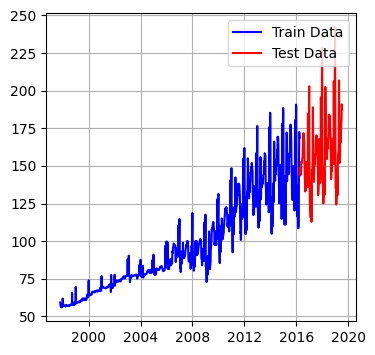

In [11]:
x_train = series[:split_time]
time_train = time[:split_time]
x_valid = series[split_time:]
time_valid = time[split_time:]

plt.figure(figsize=(4, 4))
plt.grid(True)
plt.plot(time_train, x_train, color='b', label="Train Data")
plt.plot(time_valid, x_valid, color='r', label="Test Data")
plt.legend(loc=1)
plt.show()

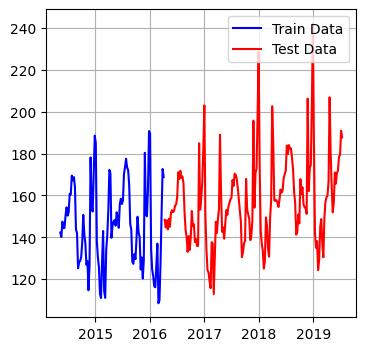

In [12]:
# Visualizing each seasonal cycle to decide window_size param
x_train = series[:split_time]
time_train = time[:split_time]
x_valid = series[split_time:]
time_valid = time[split_time:]

plt.figure(figsize=(4, 4))
plt.grid(True)
plt.plot(time_train[-100:], x_train[-100:], color='b', label="Train Data")
plt.plot(time_valid, x_valid, color='r', label="Test Data")
plt.legend(loc=1)
plt.show()

# Utilities:

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    
    return forecast

In [16]:
# Defining parameters
window_size = 56
batch_size = 28
shuffle_buffer = 1000

In [174]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer)

In [175]:
# Checking the windowed training set:
list(train_set.take(2).as_numpy_iterator())

[(array([[ 83.9 ,  86.67,  94.8 , ..., 101.49, 106.78, 105.89],
         [ 93.66,  90.67,  93.15, ...,  83.73,  83.66,  86.03],
         [ 84.03,  83.85,  85.15, ...,  88.71,  89.08,  90.02],
         ...,
         [137.8 , 137.25, 138.23, ..., 149.23, 146.99, 152.02],
         [ 57.66,  57.28,  57.68, ...,  61.15,  61.82,  61.16],
         [ 77.21,  75.16,  76.71, ...,  79.6 ,  79.32,  80.96]]),
  array([101.57,  94.26,  90.19, 133.63, 127.89,  77.83,  83.4 , 140.37,
         126.93,  75.24, 166.19, 109.49,  73.3 , 117.15,  99.82, 111.81,
          79.81, 104.29, 190.72,  67.08,  90.24, 147.5 , 107.76, 120.49,
         117.47, 150.08,  60.91,  79.37])),
 (array([[70.12, 69.85, 70.01, ..., 75.11, 75.03, 74.73],
         [61.58, 61.13, 62.  , ..., 66.78, 66.61, 66.89],
         [72.29, 72.87, 73.39, ..., 76.88, 90.39, 76.91],
         ...,
         [64.37, 64.3 , 64.57, ..., 69.  , 68.93, 68.96],
         [68.95, 69.3 , 69.27, ..., 73.46, 73.57, 73.56],
         [91.04, 90.81, 79.86, ..

In [176]:
# Creating the validation dataset
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer)

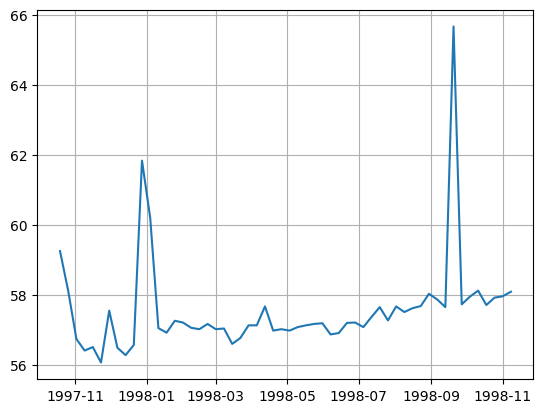

<Figure size 600x400 with 0 Axes>

In [177]:
plt.plot(time_train[:window_size], x_train[:window_size])
plt.grid(True)
plt.figure(figsize=(6, 4))
plt.show()

In [27]:
# Resetting any prior defined model weight data
tf.keras.backend.clear_session()

# Defining the model
l0 = tf.keras.layers.Dense(1)
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.SimpleRNN(20, return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.SimpleRNN(20),
    tf.keras.layers.Dense(15, activation='relu'),
    l0,
    tf.keras.layers.Lambda(lambda x: x * 400)
])

In [463]:
print(l0.get_weights())

[array([[ 0.48886377],
       [ 0.27374142],
       [ 0.6013164 ],
       [ 0.69021124],
       [-0.04941809],
       [-0.10698903],
       [ 0.4031561 ],
       [ 0.0988059 ],
       [ 0.3097927 ],
       [-0.46055788]], dtype=float32), array([0.], dtype=float32)]


In [464]:
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9),
    metrics=['mae'])

In [465]:
# Training Parameters
epochs = 200

In [466]:
# Learning Rate Scheduler (Exponential Decay)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * (10 ** (epoch / 20))
)

In [467]:
history = model.fit(train_set, epochs=epochs, validation_data=valid_set, verbose=2)

Epoch 1/200


33/33 [==============================] - 3s 30ms/step - loss: 133.0744 - mae: 133.5737 - val_loss: 88.4157 - val_mae: 88.9157
Epoch 2/200
33/33 [==============================] - 1s 19ms/step - loss: 67.7288 - mae: 68.2245 - val_loss: 65.3047 - val_mae: 65.8047
Epoch 3/200
33/33 [==============================] - 1s 19ms/step - loss: 61.9005 - mae: 62.3971 - val_loss: 74.7054 - val_mae: 75.2054
Epoch 4/200
33/33 [==============================] - 1s 19ms/step - loss: 56.8881 - mae: 57.3866 - val_loss: 73.8410 - val_mae: 74.3410
Epoch 5/200
33/33 [==============================] - 1s 19ms/step - loss: 56.1208 - mae: 56.6186 - val_loss: 75.4195 - val_mae: 75.9195
Epoch 6/200
33/33 [==============================] - 1s 19ms/step - loss: 52.7904 - mae: 53.2865 - val_loss: 66.0640 - val_mae: 66.5640
Epoch 7/200
33/33 [==============================] - 1s 19ms/step - loss: 51.2073 - mae: 51.7050 - val_loss: 61.0148 - val_mae: 61.5148
Epoch 8/200
33/33 [==============================] - 1s 18

In [468]:
hist = history.history
loss = hist['loss']
val_loss = hist['val_loss']
mae = hist['mae']
val_mae = hist['val_mae']
epoch_life = range(len(loss))

In [469]:
# # Learning Rate Scheduler plot
# lr = hist['lr']
# plt.semilogx(lr, loss)
# plt.xlabel("Learning Rate")
# plt.ylabel("Loss")
# plt.title("Learning Rate Scheduler Helper")
# plt.grid(True)
# plt.show()

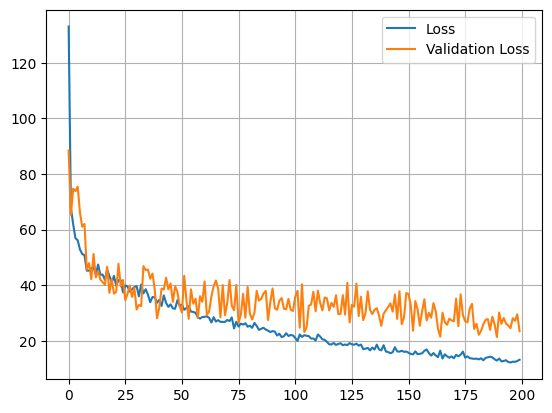

In [470]:
plt.plot(epoch_life, loss, label="Loss")
plt.plot(epoch_life, val_loss, label="Validation Loss")
plt.legend(loc=1)
plt.grid(True)
plt.show()

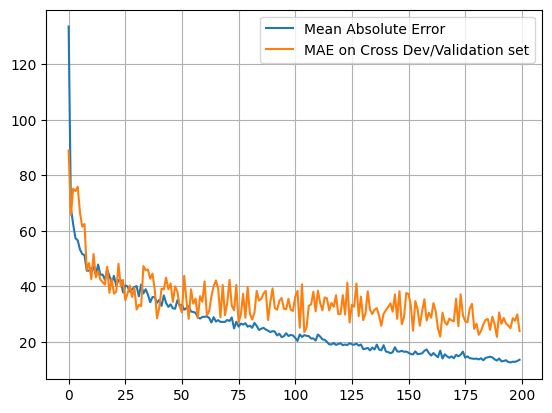

In [471]:
plt.plot(epoch_life, mae, label="Mean Absolute Error")
plt.plot(epoch_life, val_mae, label="MAE on Cross Dev/Validation set")
plt.grid(True)
plt.legend(loc=1)
plt.show()

In [472]:
# Checking layer weights:
print(l0.get_weights())

[array([[ 0.4711919 ],
       [ 0.33378643],
       [ 0.58957756],
       [ 0.5584884 ],
       [ 0.02502643],
       [-0.20352626],
       [ 0.3177144 ],
       [ 0.06012569],
       [ 0.310443  ],
       [-0.3976134 ]], dtype=float32), array([0.01670548], dtype=float32)]


In [473]:
series = np.array(series)

In [ ]:
# # To be commented out once used:
# # Model with best validation mae selected; Tuning during training no longer yielding better results
# # Model training for this not saved, however, same params and model architecture
# model.load_weights('./checkpoints/ticket-price-seq-model-weights')

In [29]:
# Checking out by forecasting for 1 window
start = 960
output = model.predict(series[start: (start + window_size)][np.newaxis])
print("Actual Price: ${}".format(series[(start + window_size)]))
print("Predicted Price: ${}".format(output.squeeze()))

KeyError: None

In [476]:
series_to_forecast = series[split_time-window_size:-1]
forecast = model_forecast(model, series_to_forecast, window_size, batch_size)
forecast = np.squeeze(forecast)

7/7 [==============================] - 0s 10ms/step


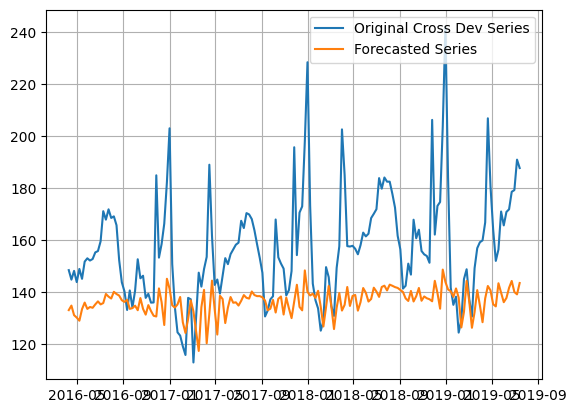

Mean Absolute Error for Forecasted Series: 21.973304748535156


In [477]:
plt.plot(time_valid, x_valid, label="Original Cross Dev Series")
plt.plot(time_valid, forecast, label="Forecasted Series")
plt.legend(loc=1)
plt.grid(True)
plt.show()

print("Mean Absolute Error for Forecasted Series: {}".format(tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()))

In [478]:
# model.save_weights('./checkpoints/ticket-price-seq-model-weights')

In [479]:
def model_predict(model, time_series, series, num_iterations, window_size):
    last_time = max(time_series.tolist())
    days_to_add = datetime.timedelta(days=7)
    series = series.tolist()
    forecast = []
    time_forecast = []
    for i in range(num_iterations):
        input_series = np.array(series, dtype='float32')
        input_series = input_series.reshape((1, window_size))
        input_series = tf.convert_to_tensor(input_series)
        output = model.predict(input_series, verbose=0)
        output = float(np.squeeze(output))
        series = series[1:]
        series.append(output)
        forecast.append(output)
        last_time = last_time + days_to_add
        time_forecast.append(last_time)
    
    return time_forecast, forecast

In [11]:
# Forecasting params
num_iterations = 150

In [481]:
time_forecast, predicted_prices = model_predict(model, time_valid, x_valid[-window_size:], num_iterations, window_size)

In [482]:
predicted_prices

[144.2116241455078,
 135.19932556152344,
 134.70660400390625,
 140.8708038330078,
 134.85348510742188,
 130.43917846679688,
 133.7151641845703,
 137.5063018798828,
 133.4528045654297,
 127.79242706298828,
 129.03335571289062,
 133.03726196289062,
 131.02490234375,
 126.54646301269531,
 126.58256530761719,
 130.0167999267578,
 129.4345703125,
 125.70140075683594,
 124.94020080566406,
 127.5957260131836,
 127.97571563720703,
 125.18453979492188,
 123.9376449584961,
 125.84275817871094,
 126.71849822998047,
 124.77538299560547,
 123.33631896972656,
 124.55655670166016,
 125.64608001708984,
 124.41582489013672,
 122.98905944824219,
 123.6474838256836,
 124.7442855834961,
 124.07855987548828,
 122.7911376953125,
 123.02254486083984,
 124.0033950805664,
 123.75301361083984,
 122.6761703491211,
 122.60816192626953,
 123.40999603271484,
 123.44129943847656,
 122.60074615478516,
 122.34598541259766,
 122.94803619384766,
 123.14974975585938,
 122.5393295288086,
 122.18863677978516,
 122.59941101

In [10]:
plt.plot(time_initial[:len(series)+num_iterations], series_initial[:len(series)+num_iterations])

NameError: name 'num_iterations' is not defined

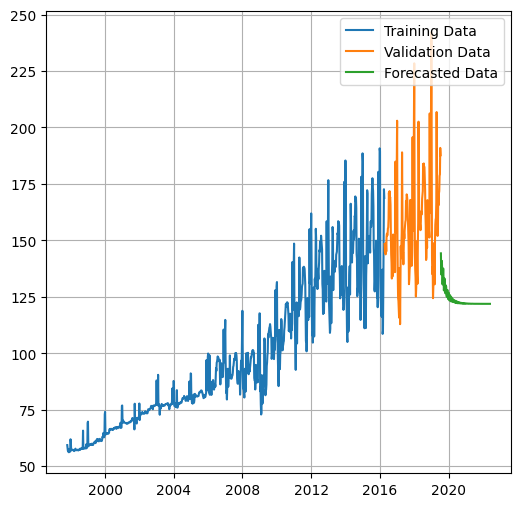

In [483]:
plt.figure(figsize=(6, 6))
plt.grid(True)
plt.plot(time_train, x_train, label="Training Data")
plt.plot(time_valid, x_valid, label="Validation Data")
plt.plot(time_forecast, predicted_prices, label="Forecasted Data")
plt.legend(loc=1)
plt.show()

In [ ]:
# Superimposing the forecasts on the actual covid-affected ticket prices of the show
plt.figure(figsize=())

### Chores: 
To perform sanity check, normalize data, and optionally set a benchmark for the model using statistical methods